In [61]:
using PyPlot

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [66]:
#Our original function which we will shift and scale
function ϕ(x::Real)
    b=abs(x)
    if b>1
        return zero(x)
    end
    return 1-b
end

#Our 1-D basis
function ϕ(l::Int,i::Int,x::Real)
    if l==-1
        return one(x)
    end
    if l==0
        return x
    end
    return ϕ((1<<l)*x - (2i - 1))
end

#Tensor product construction: our d-D basis
function ϕ{D,T<:Real}(ls::NTuple{D,Int},is::NTuple{D,Int},xs::NTuple{D,T}) 
    ans=one(eltype(xs))
    for k = 1:length(ls)
        ans *= ϕ(ls[k],is[k],xs[k])
    end
    return ans
end

function ψ(l::Int,i::Int,x::Float64)
    return ϕ((1<<l) * x - i)
end

# ψ{D}(ls::NTuple{D,Int}, is::NTuple{D,Int}, ....)
function ψ{D,T<:Real}(ls::NTuple{D,Int}, is::NTuple{D,Int}, xs::NTuple{D,T})
    ans=1
    for k = 1:length(ls)
        ans *= ψ(ls[k],is[k],xs[k])
    end
    return ans
end

#Quick plotting methods for 1-D and 2-D
function plotfunc1D(f::Function)
    xs=linspace(0,1,300)
    # y = [f((x,)) for x in xs]
    ys=[f(x,) for x in xs]
    surf=plot(xs,ys)
end

function plotfunc2D(f::Function)
    xs=linspace(0,1,250)'
    ys=linspace(0,1,250)
    zs=[f((x,y)) for x in xs, y in ys]
    surf=plot_surface(xs,ys,zs)
end

#projection of a function down a level, I don't even use it tho
function proj(f,j)
    return (x-> f(push!(x,j)))
end

function proj2(f,j)
    return (x-> f(unshift!(x,j)))
end

proj2 (generic function with 1 method)

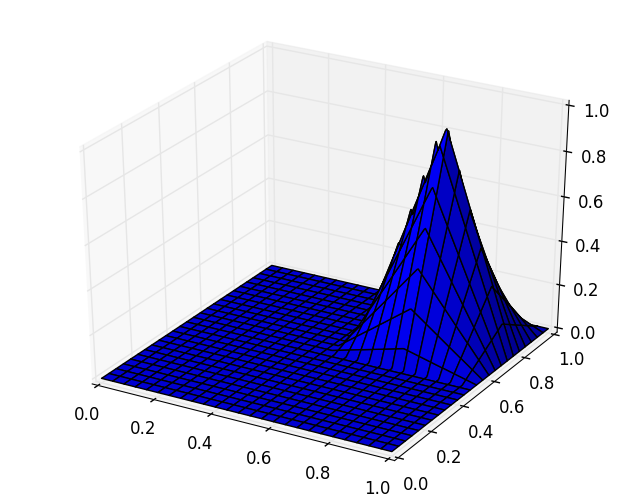

PyObject <mpl_toolkits.mplot3d.art3d.Poly3DCollection object at 0x315f6d3d0>

In [5]:
plotfunc2D(x->ϕ((2,2),(2,2),x))

In [2]:
#Standard Lagrange Basis

# function standardCoefficients{D}(f::Function, l::NTuple{D,Int})
#     if length(l)==1
#         return cat(1,[f([j]) for j in 0:Float32(2)^-l[1]:1])
#     end
#     return cat(length(l),[standardCoefficients(proj2(f,j),l[2:end]) for j in 0:Float32(2)^-l[1]:1]...)
# end

function standardCoefficients{D}(f::Function, ls::NTuple{D,Int})
    positions = ntuple(i -> (1<<ls[i])+1,D)
    coeffs = zeros(Float64, positions)
    for place in CartesianRange(positions)
        x = ntuple(i-> (2.0^-ls[i])*(place[i]-1),D)
        coeffs[place] = f(x) 
    end
    return coeffs
end


# function standardReconstruct(coefficients::AbstractArray, l::Array{Int}, x::Array{Float64})
#     if length(l)==1
#         return sum([coefficients[i+1]*ψ(l[1],i,x[1]) for i in 0:2^(l[1])]) #working
#     end
#     return sum([standardReconstruct(slice(coefficients,i+1,:),l[2:end],x[2:end])*ψ(l[1],i,x[1]) for i in 0:2^(l[1])])
# end

function standardReconstruct{D,T<:Real}(coefficients::AbstractArray, ls::NTuple{D,Int}, xs::NTuple{D,T})
    positions = ntuple(i -> (1<<ls[i])+1,D)
    value=0
    for place in CartesianRange(positions)
        is = ntuple(i->place[i]-1,D)
        value += coefficients[place]*ψ(ls, is, xs)
    end
    return value
end

standardReconstruct (generic function with 1 method)

In [18]:
#Hierarchical Iteration in n-D
function pos(x::Int)
    if x >= 0
        return x
    else
        return 0
    end
end

function hat_index(x::Float64,l::Int)
    if l<= 1
        return 1
    end
    if x>= 1
        return 2^(l-1)
    else
        return 1 + floor(Int, 2^(l-1) * x)
    end
end


function get_position{D}(level::CartesianIndex{D},place::CartesianIndex{D})
    x = [(0.5)^pos(level[i]-2) *(2*place[i]-1) for i in 1:D]
    return x
end

function form_array{T<:Real}(j::Real,x::Array{T})
    return [i==1?j:x[i-1] for i in 1:(length(x)+1)]
end

function project_function(f::Function, coordinate::Real)
    return (x-> f(form_array(coordinate,x)))
end

function get_coefficient{D,T<:Real}(f::Function, level::NTuple{D,Int}, x::Array{T}) #I think it's working
    if D==1
        if level[1]==1
            return f([0])
        elseif level[1]==2
            return f([1])-f([0])
        else
            middle = f(x)
            x[1] += (0.5)^(level[1]-2)
            after = f(x)
            x[1] -= 2*(0.5)^(level[1]-2)
            before = f(x)
            x[1] += (0.5)^(level[1]-2)
            return middle - 0.5 * before - 0.5 * after
        end
    else
        if level[1]==1
            return get_coefficient(project_function(f,0), level[2:end], x[2:end])
        elseif level[1]==2
            after  = get_coefficient(project_function(f,1), level[2:end], x[2:end])
            before = get_coefficient(project_function(f,0), level[2:end], x[2:end])
            return after - before
        else
            middle = get_coefficient(project_function(f,x[1]), level[2:end], x[2:end])
            x[1] += (0.5)^(level[1]-2)
            after  = get_coefficient(project_function(f,x[1]), level[2:end], x[2:end])
            x[1] -= 2*(0.5)^(level[1]-2)
            before = get_coefficient(project_function(f,x[1]), level[2:end], x[2:end])
            x[1] += (0.5)^(level[1]-2)
            return middle - 0.5 * before - 0.5 * after
        end
    end
end


get_coefficient (generic function with 1 method)

In [12]:
function hier_coefficients{D}(f::Function, ls::NTuple{D,Int})
    coeffs = Dict{CartesianIndex{D}, Array{Float64,D}}()
    for level in CartesianRange(ls) #This really goes from -1 to l_i for each i
        ks = ntuple(i -> 1<<pos(level[i]-3), D)  #This sets up a specific k+2 vector
        level_coeffs = zeros(ks)
        for place in CartesianRange(ks)
            x = get_position(level, place) #This is an array obtained from place that will be manipulated
            level_coeffs[place]=get_coefficient(f,ntuple(i -> level[i], D),x)
        end
        coeffs[level] = level_coeffs
    end
    return coeffs
end

hier_coefficients (generic function with 1 method)

In [13]:
function sparse_coefficients(f::Function, n::Int, D::Int)
    coeffs = Dict{CartesianIndex{D}, Array{Float64,D}}()
    ls = ntuple(i->(n+2),D)
    for level in CartesianRange(ls) #This really goes from -1 to l_i for each i
        diag_level=0;
        for i in 1:D
            diag_level+=level[i]
        end
        if diag_level > n + 2*D #If we're outside the region we care about, just don't compute coeffs
            continue
        else  #Otherwise we'll go ahead and DO IT
            ks = ntuple(i -> 1<<pos(level[i]-3), D)  #This sets up a specific k+2 vector
            level_coeffs = zeros(ks)
            for place in CartesianRange(ks)
                x = get_position(level, place) #This is an array obtained from place that will be manipulated
                level_coeffs[place]=get_coefficient(f,ntuple(i -> level[i], D),x)
            end
            coeffs[level] = level_coeffs
        end
    end
    return coeffs
end

sparse_coefficients (generic function with 1 method)

In [56]:
#this will work for both sparse and full cases
#it also generalizes decently nicely to the DG case
function reconstruct{D,T<:Real}(coefficients::Dict{CartesianIndex{D}, Array{Float64,D}}, x::NTuple{D,T})
    value = 0
    for key in keys(coefficients)
        level = ntuple(i->key[i]-2,D)
        place = ntuple(i->hat_index(x[i],level[i]),D)
        #@show coefficients[key]
        #@show (coefficients[key])[CartesianIndex{D}(place)]
        value += (coefficients[key])[CartesianIndex{D}(place)]*ϕ(level,place,x)
    end
    return value
end

reconstruct (generic function with 2 methods)

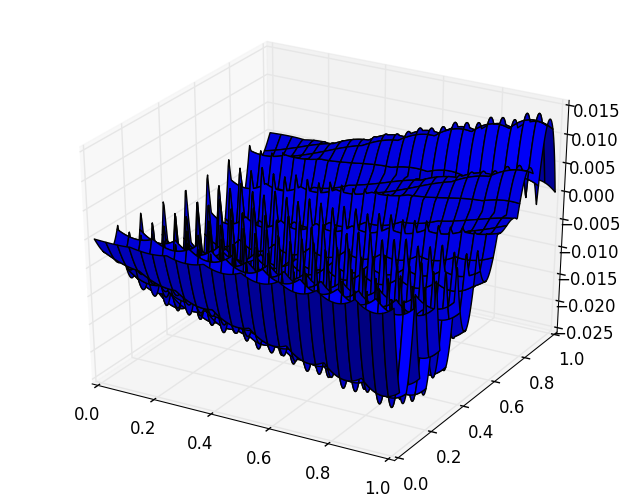

PyObject <mpl_toolkits.mplot3d.art3d.Poly3DCollection object at 0x326589c50>

In [65]:
plotfunc2D(x->reconstruct(coeffs,(x[1], x[2]))-sin(pi*x[1]+x[2]))


In [42]:
coeffs[ CartesianIndex{2}((5,3))][CartesianIndex{2}((3,1))]

0.005845593015309791

In [16]:
scoeffs = sparse_coefficients(x->sin(pi*x[1]+x[2]), 5,2);
coeffs = hier_coefficients(x->sin(pi*x[1]+x[2]), (5,5));

In [ ]:
#Not needed anymore

function hier_iterate(l::Array{Int},ki::Array{Int})
    hashMap=zeros(Array{Int},2^l[1] + 1)
    count = 1;
    if length(l)==1
        for k = -1:l[1]
            for i=1:2^(switch(k)-1)
                hashMap[count]=push!(ki,k+2,i);            
                count+=1;
            end
        end
        return hashmap
    else
        for k = -1:l[1]
            for i=1:2^(switch(k)-1)
                hashMap[count]=hier_iterate(l[2:end],push!(ki,k+2,i));
                count+=1;
            end
        end
        return hashMap
    end
end

function hier_iterate(l::Array{Int})
    return hier_iterate(l, Int[])
end

In [ ]:
function sparse_coefficients(f::Function, n::Int, d::Int)
    coeffs = Dict{CartesianIndex{D}, Array{D,Float64}}
    for level in CartesianRange(ls) #This really goes from -1 to l_i for each i
        ks = ntuple(i -> 1<<pos(level[i]-3), D)  #This sets up a specific k+2 vector
        level_coeffs = zeros(ks)
        for place in CartesianRange(ks)
            levelcoeffs(place)=get_coefficient(f,level,place)
        end
        coeffs[level] = level_coeffs
    end
end

In [ ]:
#Sparse Iteration in n-D
function sparseIterate(n::Int,d::Int,ki::Array{Int})
    hashMap=zeros(Array{Int},2^l[1] + 1)
    count = 1;
    if length(l)==1
        for k = -1:l[1]
            for i=1:2^(switch(k)-1)
                hashMap[count]=push!(ki,k+2,i);            
                count+=1;
            end
        end
        return hashmap
    else
        for k = -1:l[1]
            for i=1:2^(switch(k)-1)
                hashMap[count]=sparseIterate(n-k-1,d-1,push!(ki,k+2,i));
                count+=1;
            end
        end
        return hashMap
    end
end


function sparseIterate(n::Int,d::Int)
    return sparseIterate(n,d,Int[])
end

In [ ]:
#Sparse Iteration in n-D

In [706]:
tic()
coeffs2=standardCoefficients(x-> sin(pi*x[1]+x[2]),(3,3))
toq()

0.006711608

In [713]:
standardReconstruct(coeffs2, [3,3], [.2,.5])

LoadError: LoadError: TypeError: typeassert: expected Type{T}, got Int64
while loading In[713], in expression starting on line 1

In [697]:
coeffs2=standardCoefficients(x-> sin(pi*x[1]+x[2]),[5,5])
coeffs3=standardCoefficients(x-> sin(pi*x[1]+x[2]),[3,3,3])
coeffs=standardCoefficients(x-> sin(pi*x[1]),[5]);

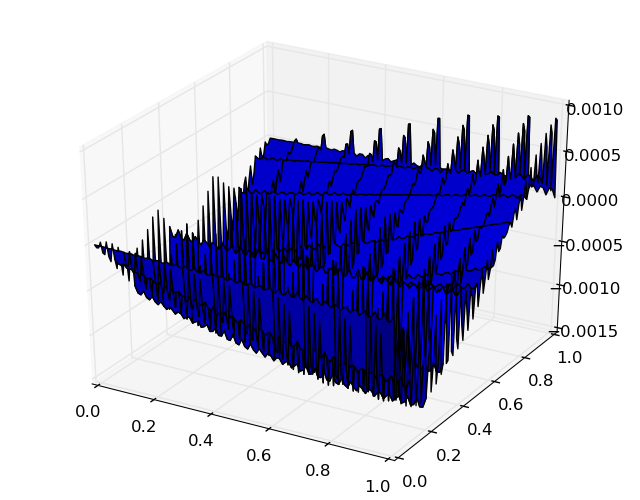

PyObject <mpl_toolkits.mplot3d.art3d.Poly3DCollection object at 0x7fe7de9bfad0>

In [554]:
plotfunc2D(x->standardReconstruct(coeffs2,[5,5],[x[1],x[2]])-0*sin(pi*x[1]+x[2]))

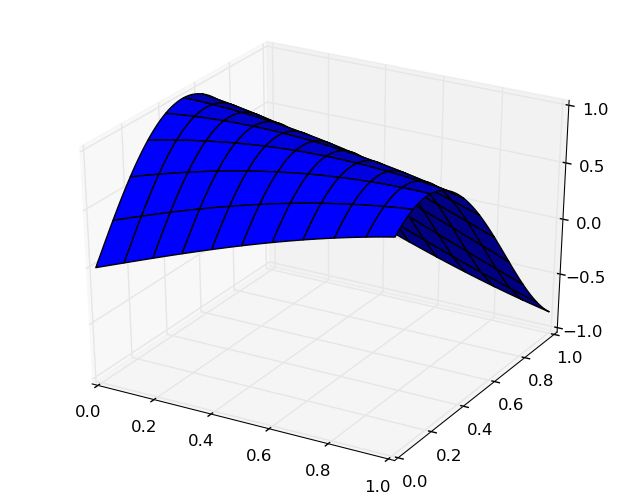

PyObject <mpl_toolkits.mplot3d.art3d.Poly3DCollection object at 0x7fe7dde61d10>

In [539]:
plotfunc2D(x->sin(pi*x[1]+x[2]))

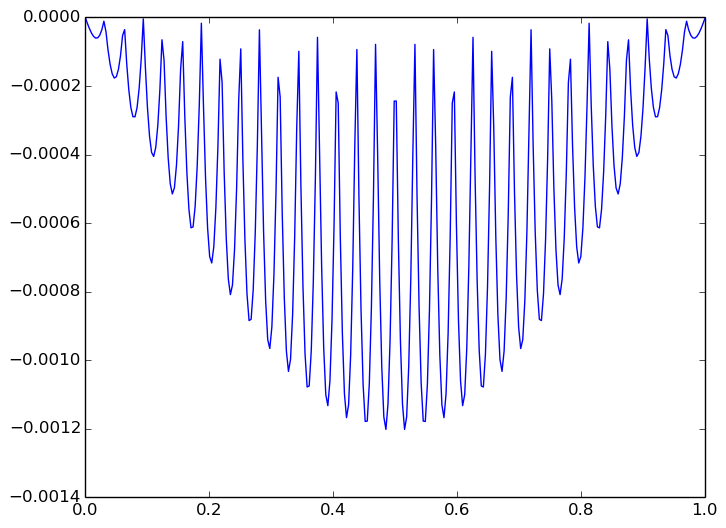

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fe7dfbebc10>

In [428]:
plotfunc1D(x->standardReconstruct(coeffs,[5],[x[1]])-sin(pi*x[1]))

In [399]:
coeffs

9x9 Array{Any,2}:
  0.0          0.124675   0.247404  …   0.681639    0.767543   0.841471
  0.382683     0.494882   0.599358      0.909757    0.954417   0.984183
  0.707107     0.789748   0.860066      0.999374    0.995988   0.977061
  0.92388      0.964382   0.989836      0.936844    0.88593    0.821191
  1.0          0.992198   0.968912      0.731689    0.640997   0.540302
  0.92388      0.86896    0.800481  …   0.41514     0.298478   0.177157
  0.707107     0.613431   0.510184      0.0353908  -0.089482  -0.212958
  0.382683     0.264513   0.142215     -0.349747   -0.463819  -0.570653
 -8.74228e-8  -0.124675  -0.247404     -0.681639   -0.767544  -0.841471

In [418]:
coeffs[3,2]

0.7897481f0

In [412]:
print(slice(coeffs,:,1))
print(slice(coeffs,1,:))

9-element SubArray{Any,1,Array{Any,2},Tuple{Colon,Int64},2}:
  0.0       
  0.382683  
  0.707107  
  0.92388   
  1.0       
  0.92388   
  0.707107  
  0.382683  
 -8.74228e-8

In [465]:
coeffs3

9x9x9 Array{Any,3}:
[:, :, 1] =
  0.0          0.124675   0.247404  …   0.681639    0.767543   0.841471
  0.382683     0.494882   0.599358      0.909757    0.954417   0.984183
  0.707107     0.789748   0.860066      0.999374    0.995988   0.977061
  0.92388      0.964382   0.989836      0.936844    0.88593    0.821191
  1.0          0.992198   0.968912      0.731689    0.640997   0.540302
  0.92388      0.86896    0.800481  …   0.41514     0.298478   0.177157
  0.707107     0.613431   0.510184      0.0353908  -0.089482  -0.212958
  0.382683     0.264513   0.142215     -0.349747   -0.463819  -0.570653
 -8.74228e-8  -0.124675  -0.247404     -0.681639   -0.767544  -0.841471

[:, :, 2] =
  0.0          0.124675   0.247404  …   0.681639    0.767543   0.841471
  0.382683     0.494882   0.599358      0.909757    0.954417   0.984183
  0.707107     0.789748   0.860066      0.999374    0.995988   0.977061
  0.92388      0.964382   0.989836      0.936844    0.88593    0.821191
  1.0          0.99